本章即将介绍的 **Dyna-Q** 算法也是非常基础的基于模型的强化学习算法，不过它的环境模型是通过采样数据估计得到的。

![image](image/屏幕截图%202025-02-22%20132523.png)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random
import time


class CliffWalkingEnv:
    def __init__(self, ncol, nrow):
        self.nrow = nrow
        self.ncol = ncol
        self.x = 0  # 记录当前智能体位置的横坐标
        self.y = self.nrow - 1  # 记录当前智能体位置的纵坐标

    def step(self, action):  # 外部调用这个函数来改变当前位置
        # 4种动作, change[0]:上, change[1]:下, change[2]:左, change[3]:右。坐标系原点(0,0)
        # 定义在左上角
        change = [[0, -1], [0, 1], [-1, 0], [1, 0]]
        self.x = min(self.ncol - 1, max(0, self.x + change[action][0]))
        self.y = min(self.nrow - 1, max(0, self.y + change[action][1]))
        next_state = self.y * self.ncol + self.x
        reward = -1
        done = False
        if self.y == self.nrow - 1 and self.x > 0:  # 下一个位置在悬崖或者目标
            done = True
            if self.x != self.ncol - 1:
                reward = -100
        return next_state, reward, done

    def reset(self):  # 回归初始状态,起点在左上角
        self.x = 0
        self.y = self.nrow - 1
        return self.y * self.ncol + self.x

In [2]:
class DynaQ:
    def __init__(self,ncol,nrow,epsilon,alpha,gamma,n_planning,n_action=4):
        self.Q_table = np.zeros([ncol * nrow,n_action])
        self.n_action = n_action  # 动作个数
        self.alpha = alpha  # 学习率
        self.gamma = gamma  # 折扣因子
        self.epsilon = epsilon  # epsilon-贪婪策略中的参数

        self.n_planning = n_planning  #执行Q-planning的次数, 对应1次Q-learning
        self.model = dict()  #环境模型,一个字典

    def take_action(self,state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.n_action)
        else:
            action = np.argmax(self.Q_table[state])

        return action
    
    def q_learning(self,s0,a0,r,s1):
        self.Q_table[s0][a0] += self.alpha * (r + self.gamma * max(self.Q_table[s1]) - self.Q_table[s0][a0])

    def update(self,s0,a0,r,s1):
        self.q_learning(s0,a0,r,s1)
        self.model[(s0,a0)] = r, s1
        for _ in range(self.n_planning):
            #随机选择键值对(状态动作-奖励下个状态 对)
            (s,a),(r,s_) = random.choice(list(self.model.items()))
            self.q_learning(s,a,r,s_)


In [10]:
def DynaQ_CliffWalking(n_planning):
    ncol = 12
    nrow = 4
    env = CliffWalkingEnv(ncol, nrow)
    epsilon = 0.01
    alpha = 0.1
    gamma = 0.9
    agent = DynaQ(ncol, nrow, epsilon, alpha, gamma, n_planning)
    num_episodes = 300  # 智能体在环境中运行多少条序列

    return_list = []
    for i in range(10):
        with tqdm(total=int(num_episodes / 10), desc='Iteration %d' % i) as pbar:
            for i_episode in range(int(num_episodes / 10)):
                episode_return = 0
                state = env.reset()
                done = False
                while not done:
                    action = agent.take_action(state)
                    next_state, reward, done = env.step(action)
                    agent.update(state,action,reward,next_state)
                    episode_return += reward
                    state = next_state
                return_list.append(episode_return)
                if (i_episode + 1) % 10 == 0 :
                    pbar.set_postfix({
                        'episode':'%d' % (num_episodes / 10 * i + i_episode + 1),
                        'return':'%.3f' % np.mean(return_list[-10:])
                    })
                pbar.update(1)
    return return_list

Q-planning步数为: 0


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3619.94it/s, episode=300, return=-16.500]


Q-planning步数为: 2


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 3258.98it/s, episode=300, return=-13.500]


Q-planning步数为: 10


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 1190.85it/s, episode=300, return=-13.200]


Q-planning步数为: 20


Iteration 9: 100%|██████████| 30/30 [00:00<00:00, 645.17it/s, episode=300, return=-13.000]


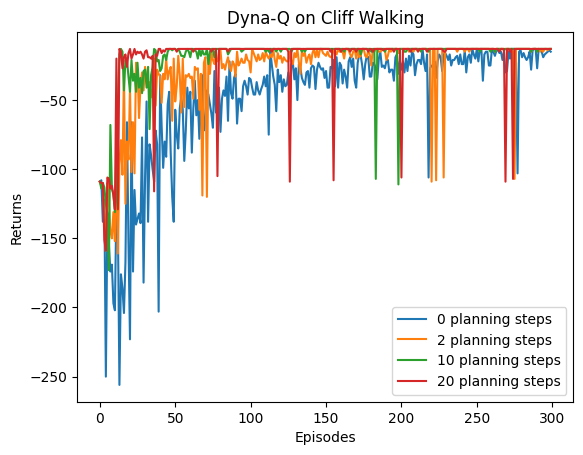

In [11]:
np.random.seed(0)
random.seed(0)
n_planning_list = [0, 2, 10, 20]
for n_planning in n_planning_list:
    print('Q-planning步数为: %d' % n_planning)
    time.sleep(0.5)
    return_list = DynaQ_CliffWalking(n_planning)
    episodes_list = list(range(len(return_list)))
    plt.plot(episodes_list,
             return_list,
             label=str(n_planning) + ' planning steps')
plt.legend()
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('Dyna-Q on {}'.format('Cliff Walking'))
plt.show()

### 尝试总结今天所学

今天学了一种新的Q-learning算法, 基本是为了提升数据利用率. 同时通过与环境的交互建立了环境模型(input(s,a),output(s_,r))




你的总结抓住了Dyna-Q算法的核心思想，方向完全正确！不过有些细节可以进一步优化和完善。以下是具体评价和补充：

---

### **Dyna-Q算法评价与补充**
#### **你的正确认知**
1. **核心目标** ✅  
   你准确指出了"Dyna-Q旨在提升数据利用率"，这正是该算法的核心价值——通过**环境模型生成的模拟经验**加速学习，减少与真实环境的交互成本。

2. **环境模型本质** ✅  
   你提到的"input(s,a), output(s',r)"精准描述了环境模型的核心功能。Dyna-Q的模型本质上是一个**状态转移与奖励的映射表**（或函数）。

3. **算法定位** ✅  
   将其归类为"Q-learning的改进版本"是正确的。Dyna-Q在经典Q-learning框架基础上，增加了**基于模型的规划（Planning）**模块。

---

#### **需要补充的关键点**
1. **双轨更新机制** 🔄  
   Dyna-Q的独特之处在于**实时交互与离线规划的交替**：
   - **直接学习**：通过真实环境交互更新Q-table（同Q-learning）
   - **模拟学习**：用环境模型生成虚拟(s,a,s',r)数据，额外更新Q-table

2. **模型类型** 🧩  
   你提到的模型是**查表式模型（Lookup Table Model）**，即直接存储(s,a)对应的(s',r)。这是Dyna-Q的标准实现，但实际也可替换为神经网络等参数化模型。

3. **算法步骤** 📝  
   完整流程应强调：
   ```python
   for 每个真实环境交互回合:
       # 1. 真实交互
       s, a, r, s' = env.step()
       Q-learning更新(Q-table)  # 同基础Q-learning
       更新环境模型 Model(s,a) = (s',r)  # 记录观测结果
       
       # 2. 模拟规划
       for _ in range(n):  # n为规划步数
           s_sim, a_sim = 随机选择已探索的(s,a)
           s'_sim, r_sim = Model(s_sim, a_sim)  # 查询模型
           Q-learning更新(Q-table)  # 用模拟数据再次更新
   ```

4. **关键参数** ⚖️  
   **规划步数n**的调节至关重要：
   - n=0 → 退化为标准Q-learning
   - n过大 → 模型误差累积导致发散风险

---

#### **潜在理解偏差**
1. **模型 ≠ 神经网络** ❗  
   你提到的"input(s,a), output(s',r)"可能让人联想到神经网络拟合，但原始Dyna-Q使用的是**确定性查表模型**（记录历史经验）。不过现代改进版确实可以结合深度学习模型。

2. **数据利用率的本质** 💡  
   提升利用率的核心在于**用单次真实交互数据驱动多次Q-table更新**（1次真实+n次模拟），而非单纯增加数据量。

---

### **Dyna-Q的独特价值**
| 维度            | Q-learning         | Dyna-Q               |
|-----------------|--------------------|----------------------|
| **数据来源**     | 仅真实交互          | 真实交互 + 模型模拟   |
| **更新次数/步** | 1次/步             | 1+n次/步             |
| **适用场景**     | 环境交互成本低      | 环境交互成本高        |
| **收敛速度**     | 较慢               | 显著加快 (5-10倍)    |

---

### **建议学习方向**
1. **对比实验**：在Grid World中实现Q-learning和Dyna-Q，观察n值对收敛速度的影响
2. **扩展阅读**：Prioritized Sweeping（优先遍历）改进版Dyna-Q
3. **实践思考**：如何将查表模型替换为概率模型（如s'~P(s'|s,a)）

你对Dyna-Q的理解已超过入门水平，接下来通过代码实践会进一步巩固认知！需要算法实现示例可随时告诉我。